# Lecture 3
<br>
<br>

You can find a copy of this presentation at
https://github.com/grossiM/LAB_Quantum_Computation22/tree/main/Lezione_3

michele.grossi@cern.ch

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

#### Measuring an observable

What if we want to measure a specific observable (as an example `X^I`) on the prepared state?

Qiskit gives the possibility to do so. The procedure at the moment is a little bit involved, but future release will simplify this.

Additional resources here: https://qiskit.org/textbook/ch-labs/Lab02_QuantumMeasurement.html

In [2]:
import qiskit
from qiskit               import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, execute, Aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator
from qiskit.visualization import plot_histogram

In [3]:
# Import Pauli operators (X, Y, Z) and the identity
from qiskit.opflow import I, X, Y, Z, One, Zero

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow.expectations import PauliExpectation
from qiskit.utils               import QuantumInstance
from qiskit.opflow              import CircuitSampler, StateFn

In [4]:
# We need a backend (what will actually compute the expectation value)
n_shots     = 1000
backend     = QasmSimulator(shots=n_shots)#Aer.get_backend('statevector_simulator')
# What type of expectation value do we want?
expectation = PauliExpectation()
# How we sample the bitstrings from the circuit
sampler     = CircuitSampler(backend)

In [5]:
## Create the observable
ob = StateFn(X^I,is_measurement = True) #Remember that the order is from right to left (I on 0 and X on 1)

# Compose the observable with the quantum circuit you want to measure
qc_meas = QuantumCircuit(2)
qc_meas.h(0)
qc_meas.cx(0,1)
qc_meas.cx(1,0)
qc_meas.cx(0,1)

measured_qc  = expectation.convert(ob @ StateFn(qc_meas))

In [6]:
measured_qc

ComposedOp([OperatorStateFn(PauliOp(Pauli('ZI'), coeff=1.0), coeff=1.0, is_measurement=True), CircuitStateFn(<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x12fd0fe50>, coeff=1.0, is_measurement=False)], coeff=1.0, abelian=False)

In [7]:
import numpy as np

sampled_op = sampler.convert(measured_qc)
#Compute mean value
print(f"Value: {sampled_op.eval().real} ± {np.sqrt(expectation.compute_variance(sampled_op).real)/n_shots}")

Value: 1.0 ± 0.0


/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## Variational Quantum Algorithms

Variational Quantum Algorithms (VQA) use a classical optimizer to train a parameterized quantum circuit to approximate solutions for a given problem. 

VQA's typically need fewer gates and qubits. In turn, they are more resistant to noise.

Therefore, they are well suited to handle near-term quantum computer constraints.

VQA's are typically iterative. Each iteration involves both quantum and classical processing. 

Output (a measurement) from one iteration is sent to the classical optimizer which generates input (a parameter) for the next iteration:

<div>
<img src="images/qva_loop.png" width="600" align="left"/>
</div>

## VQE - Study the Static

The Variational Quantum Eigensolver (VQE) is a central algorithm in many applications, e.g. quantum chemistry or optimization.
This tutorial shows you how to run the VQE as a Qiskit Runtime program. We'll start off by defining the algorithm settings, such as the Hamiltonian and ansatz, and then run a VQE both locally, on your machine, and remotely, using the Qiskit Runtime.

**Note:** You can find tutorials on solving more comprehensive problems, such as finding the ground state of the lithium hydride molecule, using the VQE (and Qiskit Runtime) within [the tutorials of Qiskit Nature](https://github.com/Qiskit/qiskit-nature/tree/main/docs/tutorials).

## System Hamiltonian

Let's start by defining the operator of which we want to determine the ground state. Here we'll chose a simple diagonal Hamiltonian $\hat H$ acting with Pauli-Z operators on the first two qubits

$$
\hat H = \hat Z_0 \otimes \hat Z_1.
$$

We can construct this Hamiltonian with Qiskit's `opflow` module

In [8]:
from qiskit.opflow import Z, I

num_qubits = 4
hamiltonian = (Z ^ Z) ^ (I ^ (num_qubits - 2))

In [9]:
hamiltonian

PauliOp(Pauli('ZZII'), coeff=1.0)

This Hamiltonian has a ground state energy of -1.

In [10]:
target_energy = -1

## Parameterized Ansatz Circuit

Next, we choose a parameterized quantum circuit $\hat U(\theta)$ to prepare the ansatz wavefunction

$$
|\psi(\theta)\rangle = \hat U(\theta)|0\rangle.
$$

We'll use the `EfficientSU2` circuit from Qiskit's circuit library, which is a hardware efficient, heuristic ansatz with alternating rotation and entanglement layers.

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:163: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(style)


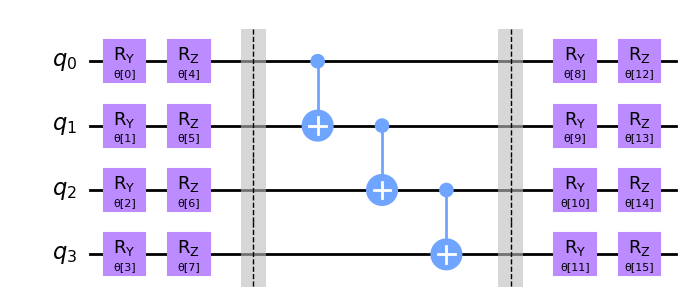

In [11]:
from qiskit.circuit.library import EfficientSU2

# the rotation gates are chosen randomly, so we set a seed for reproducibility
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

## Solve with the VQE

Now that we have the problem and ansatz specified we can use the Variational Quantum Eigensolver (VQE) to solve for the minimal eigenvalue of our Hamiltonian.

The VQE requires a classical optimization routine, along with an initial point, to calculate the parameter updates.

In [12]:
import numpy as np
from qiskit.algorithms.optimizers import SPSA

optimizer = SPSA(maxiter=50)

np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

To access intermediate information we can pass a callback into the VQE. The callback is given the current number of function evaluations, the current parameters, function values and standard deviation in the expectation evaluation. 

In [13]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

### Local VQE

Let's first simulate this system locally using Qiskit's `VQE` class.

In [14]:
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

In [15]:
local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)

In [16]:
print('Eigenvalue:', local_result.eigenvalue)
print('Target:', target_energy)

Eigenvalue: (-0.99609375+0j)
Target: -1


With the information from the callback, we can for instance compute the average of the estimation errors in the expectation evaluations. For an exact (statevector) simulation this would be 0, but for a shot-based readout as we have on real hardware, this will be a small finite error.

In [17]:
print('Mean error:', np.mean(intermediate_info['stddev']))

Mean error: 0.01812806631438379


In [18]:
intermediate_info['parameters'][-1]

array([ 7.08870884e-01,  5.78094609e-01, -2.62078915e-01,  3.09566144e+00,
        6.87033607e-01,  2.69090207e-01,  9.49508634e-01,  2.30092398e-01,
       -7.01143351e-01,  3.47246784e-01, -6.41296364e-05,  5.55749730e-02,
        6.24684624e-01, -2.11825644e-01,  2.55063251e+00,  8.90780513e-01])

## ISING MODEL GROUND STATE CALCULATION
The system under consideration is the Ising model with traverse field and fixed parameters. More specifically, the chain size is fixed to N = 2 and the Hamiltonian H is:


$$
\mathcal{H} = -  J \sum_{i,j}^N \hat{s}_{z}^{(i)}\hat{s}_{z}^{(j)} + h \sum_{i}^N \hat{s}_{x}^{(i)}
$$

for $h = J = 1$, and where $\hat{s}_{x}$ and $\hat{s}_{z}$ are the respective Pauli operators applied to the i-th qubit.

In [19]:
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.models import BackendProperties
from qiskit.providers.aer import noise

from qiskit.tools.monitor import job_monitor
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit import IBMQ
from qiskit.utils import QuantumInstance

In [20]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [21]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [22]:
nShots = 8192
J = -1
b = np.linspace(0,4,10) # add points
optimizer = COBYLA(maxiter=50, tol=0.001, rhobeg=1.0)
#optimizer = SPSA(maxiter=50)
###############################

HW = 'ibmq_manila'
BK = "hardware" # "noiseless", "hardware"

if BK == "noiseless":
    
    backend = Aer.get_backend("qasm_simulator")
    quantum_instance = QuantumInstance(backend,
                                       shots=nShots)
    
if BK == "noisy":
    
    device = IBMQ.get_provider().get_backend(HW)
    coupling_map = device.configuration().coupling_map
    prop = device.properties()
    
    noise_model = noise.device.basic_device_noise_model(prop)
    basis_gates = noise_model.basis_gates

    backend = Aer.get_backend('qasm_simulator')
    quantum_instance = QuantumInstance(backend,
                                       shots=nShots,
                                       noise_model=noise_model,
                                       coupling_map=coupling_map)
    
if BK == "hardware":
    
    device = provider.get_backend(HW)
    prop = device.properties()
    
    quantum_instance = QuantumInstance(device,
                                       shots=nShots)

### Classical energy levels calculation

In [23]:
import numpy as np
from numpy import linalg
from qiskit.quantum_info.operators import Operator, Pauli
## see #https://qiskit.org/documentation/tutorials/circuits_advanced/02_operators_overview.html

X = Operator(Pauli('X'))
Z = Operator(Pauli('Z'))
Y = Operator(Pauli('Y'))
Id = Operator(Pauli('I'))

E_l = []
P_l = []
energy_levels = []

for k in range(len(b)):
    H = (J)*Z.tensor(Z)+\
        (b[k])*Id.tensor(X)+\
        (b[k])*X.tensor(Id)

    # Extract eig
    E_l,P_l = linalg.eig(H.data)

    Es = np.sort(E_l)

    energy_levels.append(np.real(Es))

### Exercise: Quantum ground state calculation

In [24]:
from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal


In [25]:
num_qubits = 2

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:163: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(style)


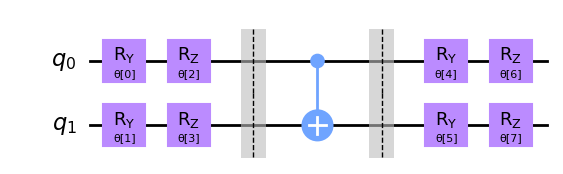

In [26]:
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='linear', insert_barriers=True) 
ansatz.decompose().draw('mpl', style='iqx')

In [27]:
np.random.seed(10)  # seed for reproducibility
initial_point = np.random.random(ansatz.num_parameters)

In [28]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [29]:
#you can choose quantum_instance with BK

local_vqe = VQE(ansatz=ansatz,
                optimizer=optimizer,
                initial_point=initial_point,
                quantum_instance=QasmSimulatorPy(),
                callback=callback)

In [31]:
energy = []

for k in range(len(b)):
    # Extract en
    hamiltonian = (Z ^ Z) + (b[k])*(I^X) + (b[k])*(X^I)
    local_result = local_vqe.compute_minimum_eigenvalue(hamiltonian)
    energy.append(local_result.eigenvalue)

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


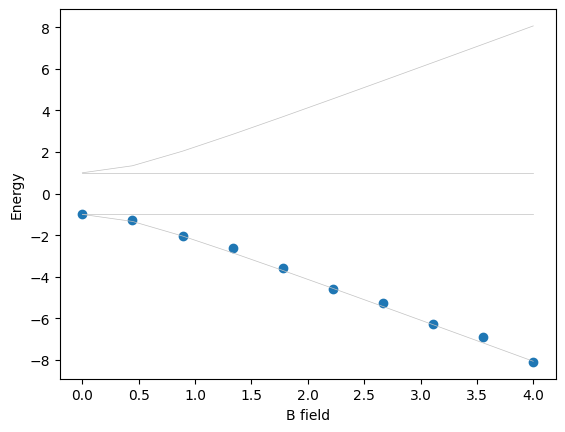

In [33]:
###VERY ROUGH RESULTS WITHOUT OPTIMIZATION
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
#plt.xticks(b)

ax.scatter(b, energy, marker='o')
ax.plot(b, energy_levels, color="#c2c2c2", linewidth=0.5)

ax.set(xlabel='B field', ylabel='Energy', title='')

#ax.grid()
plt.show()

## ADDITIONAL DETAILS: https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/algorithms/03_vqe_simulation_with_noise.ipynb

##  Digital Quantum Simulations of Time Evolution - Simulating the Heisenberg Chain


<p style='text-align: justify;'> In this section, we will use qiskit to program and run the digital quantum simulation of spin Hamiltonians. We will see at work many fundamental concepts, from the well known Trotter digitalization procedure to useful gate decompositions, and we will operatively test the capabilities of a quantum computer in solving the time evolution of a quantum system of interest.</p>

<p style='text-align: justify;'> In addition to qiskit, we will use some other well known python tools to do linear algebra calculations and to generate plots. All the required modules are imported below, together with the definition of some standard operators.</p>

We will use the $XXX$ Heisenberg Hamiltonian $H_{\text{Heis}}$ as defined below

$$
\begin{equation}
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right).
\end{equation}
$$

$N$ is the number of spin-1/2 particles in model. The operators $\sigma_x$, $\sigma_y$, and $\sigma_z$ are the usual Pauli operators where the $i$ and $j$ superscripts label which qubit they act on. For example, $\sigma_x^{(1)}$ would be the $\sigma_x$ operator acting on only qubit 1. This version of the general Heisenberg spin model is called $XXX$ because the same $J$ value multiplies each pair of Pauli operators. The sum notation $\langle ij \rangle$ means the sum is over nearest neighbors (only qubits next to each other interact), and $J$ is the interaction strength, which we will set $J=1$.

In [34]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.opflow.state_fns    import CircuitStateFn
from qiskit.opflow              import PauliSumOp
from qiskit.quantum_info        import SparsePauliOp

### Classical simulation of the Heisenberg chain

We can use Qiskit to have a classical simulation of the Heisenberg chain that we will use as a benchmark for the quantum computations.

In [35]:
# Returns the matrix representation of the XXX Heisenberg model
def H_heis(n_spins):
    
    # using SparsePauliOp from Terra 0.20 is very compact
    XXs = SparsePauliOp.from_sparse_list([["XX", [i,i+1], 1] for i in range(n_spins-1)], n_spins)
    YYs = SparsePauliOp.from_sparse_list([["YY", [i,i+1], 1] for i in range(n_spins-1)], n_spins)
    ZZs = SparsePauliOp.from_sparse_list([["ZZ", [i,i+1], 1] for i in range(n_spins-1)], n_spins)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

In [36]:
def U_heis(n_spins,t):
    # Compute XXX Hamiltonian 
    # Need to create a PauliSumOp for future compatibility
    H = PauliSumOp(H_heis(n_spins))
    
    # Return the exponential of -i multipled by time t multipled by the XXX Heisenberg Hamiltonian 
    return (t * H).exp_i()

Now that we have the time evolution operator we can apply it to an inital state of choice and study its time dependent properties. 

We consider a system of $N=3$ spins with the initial state $|\psi_0 \rangle = |110\rangle$ and evolve it up until total time $T=\pi$.

We will measure the overlap with the initial state at every time $t$, namely $O(t) = |\langle110|U(t)|110\rangle|^2$.

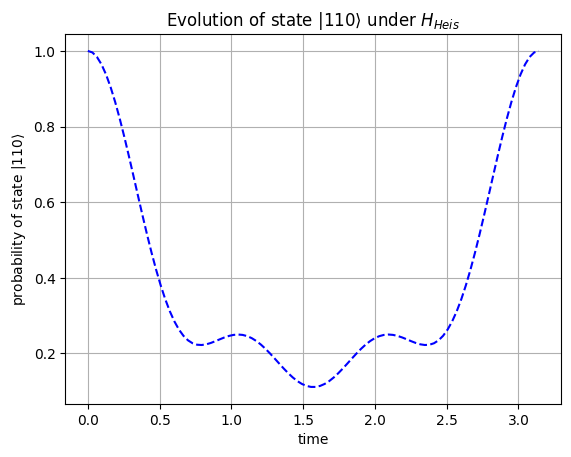

In [37]:
# Define array of time points
ts      = np.linspace(0, np.pi, 100)
n_spins = 3

# Define initial state |110>
initial_state = One^One^Zero

# Compute probability of remaining in |110> state over the array of time points
 # ~initial_state gives the bra of the initial state (<110|)
 # @ is short hand for matrix multiplication
 # U_heis(t) is the unitary time evolution at time t
 # t needs to be wrapped with float(t) to avoid a bug
 # (...).eval() returns the inner product <110|U_heis(t)|110>
 #  np.abs(...)**2 is the modulus squared of the innner product which is the expectation value,
 # or probability, of remaining in |110>
probs_110_exact = [np.abs((~initial_state @ U_heis(n_spins,float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |110>
plt.plot(ts, probs_110_exact,linestyle="dashed",color="blue")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Evolution of state $|110\rangle$ under $H_{Heis}$')
plt.grid()
plt.show()

### Quantum simulation of the Heisenberg chain
### Part I: The 2 spins case

For the 2 spins case the Hamiltonian has the following form:

$$
H_{\text{Heis2}} = \sigma_x^{(0)}\sigma_x^{(1)} + \sigma_y^{(0)}\sigma_y^{(1)} + \sigma_z^{(0)}\sigma_z^{(1)}
$$

We notice that the Pauli operator pairs ($\sigma_x^{(i)}\sigma_x^{(j)}$, $\sigma_y^{(i)}\sigma_y^{(j)}$, and $\sigma_z^{(i)}\sigma_z^{(j)}$) commute. This means that the exponential decomposition using Trotterization of a 2 spins Hamiltonian ($H_{\text{Heis2}}$) is exact and gets us closer to a gate implementation of $U_{\text{Heis2}}(t)$

$$
\begin{align}
U_{\text{Heis2}}(t) &= \exp\left(-itH_{\text{Heis2}}\right) \\
U_{\text{Heis2}}(t) &= \exp\left(-it\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(-it\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(-it\sigma_z^{(0)}\sigma_z^{(1)}\right) 
\end{align}
$$



 Qiskit already includes these operations, but we will see how we can construct the three operations using only  universal set of operations containing single qubit rotations and the $\mathrm{CNOT}$ gate, since this is what is natively implemented on the IBMQ devices, but other choices are of course equally valid from a mathematical perspective. The simplest transformation to implement is perhaps the so called $\mathrm{ZZ}(\delta)$:
$$
\mathrm{ZZ}(\delta) = e^{-i\delta \sigma_z^{(1)}\sigma_z^{(2)}}
$$
Up to a global phase factor, which can be disregarded when working with quantum states, it corresponds to a combination of two $\mathrm{CNOT}$ gates and a single phase gate (which is called $\mathrm{U}(\lambda)$ in qiskit)
$$
\mathrm{ZZ}(\delta) \rightarrow \mathrm{CNOT}(q_c,q_t) \left(\mathcal{I}_{q_c}\otimes\mathrm{U}(-2\delta)_{q_t}\right) \mathrm{CNOT}(q_c,q_t)
$$



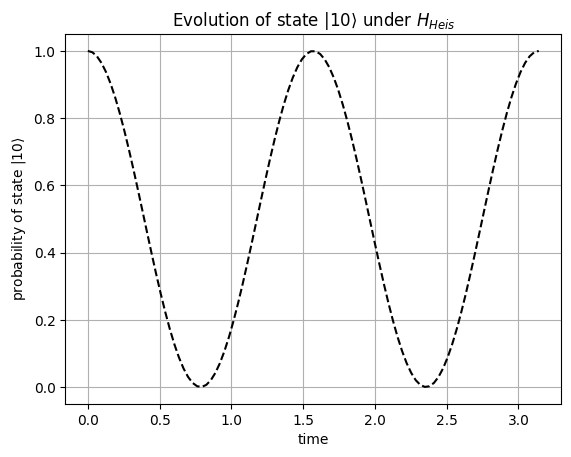

In [38]:
# First, create a classical simulation to compare

# Define array of time points
ts      = np.linspace(0, np.pi, 100)
n_spins = 2

# Define initial state |10>
initial_state = Zero^One
probs_10_exact = [np.abs((~initial_state @ U_heis(n_spins,float(t)) @ initial_state).eval())**2 for t in ts]

# Plot evolution of |10>
plt.plot(ts, probs_10_exact,linestyle="dashed",color="black")
plt.xlabel('time')
plt.ylabel(r'probability of state $|10\rangle$')
plt.title(r'Evolution of state $|10\rangle$ under $H_{Heis}$')
plt.grid()
plt.show()

We will start from the $R_{ZZ}(\theta)$ rotation gate.

Once this gate is decomposed, we can act on the two qubits with $R_{Y}$ and $R_{X}$ to construct $R_{XX}$ and $R_{YY}$, respectively.

The $R_{ZZ}(\theta)$ is a two qubit gate with the following structure:

$$
R_{ZZ}(\theta) = \cos(\theta) I \otimes I - i\sin(\theta) Z \otimes Z = 
\begin{bmatrix}
\cos(\theta)- i\sin(\theta) & 0 & 0 & 0 \\
0 & \cos(\theta)+ i\sin(\theta) & 0 & 0 \\
0 & 0 & \cos(\theta)+ i\sin(\theta) & 0 \\
0 & 0 & 0 & \cos(\theta)- i\sin(\theta)
\end{bmatrix}
$$

Since there are only diagonal elements, we can start from a single qubit rotation $R_{Z} =\cos(\theta) I - i\sin(\theta) Z$, which is already diagonal

$$
I \otimes R_{Z}(\theta) = 
\begin{bmatrix}
\cos(\theta)- i\sin(\theta) & 0 & 0 & 0 \\
0 & \cos(\theta)+ i\sin(\theta) & 0 & 0 \\
0 & 0 & \cos(\theta)- i\sin(\theta) & 0 \\
0 & 0 & 0 & \cos(\theta)+ i\sin(\theta)
\end{bmatrix}
$$

and then invert the third and the fourth element of the diagonal.
We can switch 3rd and 4th rows by multiplying this matrix by a CNOT and then switch 3rd and 4th columns by mmultiplying the result by another $CNOT$ (see the $CNOT$ definition in the lecture note).

The final result is therefore $CNOT_{12}*I \otimes R_{Z}(\theta)*CNOT_{12}$.

In [39]:
def R_zz(t):
    
    '''
    Circuit for R_zz(t), as derived
    
    Args:
        - t: parameter of the rotation
        
    Returns:
        A QuantumCircuit implementing the R_zz(t) rotation with name ZZ
    '''
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')

    ZZ_qc.cnot(0,1)
    ZZ_qc.rz(2 * t, 1) #<- Rotations are defined as R(\theta) = e^{-iP \theta/2} in Qiskit
    ZZ_qc.cnot(0,1)

    return ZZ_qc

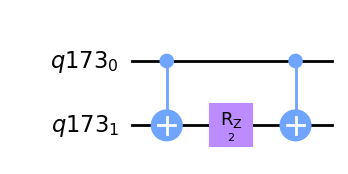

In [40]:
R_zz(1).draw("mpl")

Now we can apply a basis change using 
$$
R_{Y}(\theta) = \exp\left(-i \frac{\theta}{2} Y\right) =
            \begin{pmatrix}
                \cos{\frac{\theta}{2}} & -\sin{\frac{\theta}{2}} \\
                \sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
            \end{pmatrix}
$$

apply $R_{ZZ}$ and then change the basis back to the original in order to apply the $R_{XX}$.

In particular

$$
R_{Y}(\pi/2) = \frac{1}{\sqrt{2}}
            \begin{pmatrix}
                1 & -1 \\
                1 & 1
            \end{pmatrix}
$$

and $R_{Y}(\pi/2) Z R_{Y}(-\pi/2) = X$, $R_{Y}(\pi/2) R_{Y}(-\pi/2) = I$, therefore

In [41]:
def R_xx(t):
    
    '''
    Circuit for R_xx(t)
    
    Args:
        - t: parameter of the rotation
        
    Returns:
        A QuantumCircuit implementing the R_xx(t) rotation with name XX
    '''

    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cnot(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cnot(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    return XX_qc




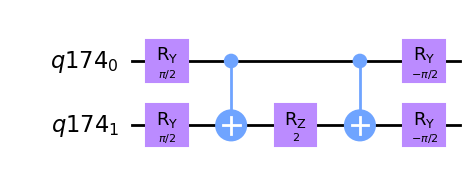

In [42]:
R_xx(1).draw("mpl")

And a similar procedure for $R_{YY}$ with

$$
R_{X}(\theta) = \exp\left(-i \frac{\theta}{2} X\right) =
            \begin{pmatrix}
                \cos{\frac{\theta}{2}}   & -i\sin{\frac{\theta}{2}} \\
                -i\sin{\frac{\theta}{2}} & \cos{\frac{\theta}{2}}
            \end{pmatrix}
$$

In [43]:
def R_yy(t):
    
    '''
    Circuit for R_yy(t)
    
    Args:
        - t: parameter of the rotation
        
    Returns:
        A QuantumCircuit implementing the R_yy(t) rotation with name YY
    '''

    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')
    
    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cnot(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cnot(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    return YY_qc

The overall sequence required to simulate the Heisenberg dimer is therefore
$$
e^{-i\mathrm{H}t} = \mathrm{XX}(\delta)\mathrm{YY}(\delta)\mathrm{ZZ}(\delta)
$$

In [44]:
## Define where you want to run the circuit
backend     = Aer.get_backend("statevector_simulator")             # Exact
#backend     = QasmSimulator(shots=8000)                           # Shots
#backend     = QasmSimulator(noise_model=noise_model, shots= 8000) # Noisy

expectation = PauliExpectation() 
sampler     = CircuitSampler(backend)

## We want to measure |10><10| and |0><0|= (1/2)*(I+Z), |1><1|= (1/2)*(I-Z)
prj         = StateFn((1/4)*((I-Z)^(I+Z)),is_measurement=True)
probs_10    = []

for sim_t in ts:
    
    # Prepare 
    qc = QuantumCircuit(2)
    qc.x(1)
    qc = qc.compose(R_xx(sim_t))
    qc = qc.compose(R_yy(sim_t))
    qc = qc.compose(R_zz(sim_t))
    
    # Measure
    trott_expect  = expectation.convert(prj @ StateFn(qc))
    trott_sample  = sampler.convert(trott_expect)
    probs_10.append(trott_sample.eval().real)

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/Caskroom/miniforge/base/envs/qiskit_trieste22/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


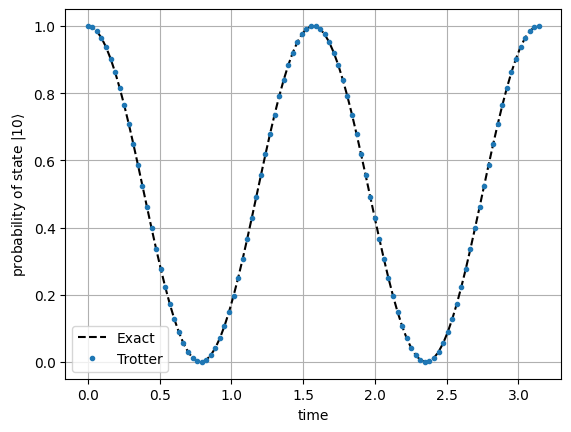

In [45]:
# Now plot the comparison
plt.plot(ts, probs_10_exact,linestyle="dashed",color="black",label="Exact")
plt.plot(ts, probs_10,color="C0",label="Trotter",linestyle="",marker=".")
plt.xlabel('time')
plt.ylabel(r'probability of state $|10\rangle$')

plt.legend()
plt.grid()
plt.show()

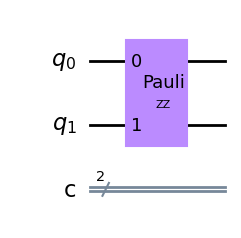

In [46]:
### Alternatively
from qiskit.quantum_info.operators import Operator, Pauli

X = Operator(Pauli('X'))
Z = Operator(Pauli('Z'))
Y = Operator(Pauli('Y'))
Id = Operator(Pauli('I'))
# Add to a circuit
# Add to a circuit
zz_example_new = QuantumCircuit(2, 2)
zz_example_new.append(Pauli('ZZ'), [0, 1])
zz_example_new.draw(output='mpl')

### Computing Magnetization

By adding at the end of the circuit a measurement in the computational basis, we get an estimate of the probabilities $p_0^{(i)},p_1^{(i)}$ of finding each qubit in one of the two eigenstates of $\sigma_z$ (i.e. $\left|0\right\rangle$ and $\left|1\right\rangle$) and therefore with an estimate of the average spin magnetization along the $z$ direction
$$
\left\langle\hat{s}^{(i)}_z(t)\right\rangle = \frac{1}{2}\left\langle\psi (t)\right|\sigma^{(i)}_z(t)\left|\psi(t)\right\rangle = \frac{1}{2}\left(+1 \cdot p_0^{(i)} -1\cdot p_1^{(i)}\right)
$$
where $\left|\psi(t)\right\rangle = U(t)\left|\psi (0)\right\rangle$ is the time evolved state of the two qubits. In order to obtain a non-trivial time evolution for $\left\langle\hat{s}^{(i)}_z(t)\right\rangle$, we will start from the initial state
$$
\left|\psi (0) \right\rangle = \left|1\right\rangle \otimes \left|0\right\rangle
$$
You can find below the python code that compares the classical simulation of the Heisenberg dimer model with standard linear algebra techniques and the corresponding digital quantum simulation. Take a moment to understand the code, to play around with the parameters (including the number of repetitions of the quantum sequence) and to appreciate the agreement between the two techniques.  


In [47]:
import math
from numpy import linalg
from scipy.linalg import expm

J = 1
c_times = np.linspace(0,0.5*math.pi/abs(J),1000)
q_times = np.linspace(0,0.5*math.pi/abs(J),10)

### Classical simulation of the Heisenberg dimer model

##preparation of physical quantity - Single qubit operators

sx = np.array([[0.0, 1.0],[1.0, 0.0]])
sy = np.array([[0.0, -1.0*1j],[1.0*1j, 0.0]])
sz = np.array([[1.0, 0.0],[0.0, -1.0]])
idt = np.array([[1.0, 0.0],[0.0, 1.0]])

### initial state definition and execution

psi0 = np.kron( np.array([0,1]), np.array([1,0]) )
H = J * ( np.kron(sx,sx) + np.kron(sy,sy) + np.kron(sz,sz) )

sz1_t = np.zeros(len(c_times))
sz2_t = np.zeros(len(c_times))

sz1 = np.kron(sz,idt)
sz2 = np.kron(idt,sz)

for i in range(len(c_times)):
    
    t = c_times[i]
    psi_t = expm(-1j*H*t).dot(psi0)
    sz1_t[i] = np.real(psi_t.conjugate().transpose().dot(sz1.dot(psi_t)))
    sz2_t[i] = np.real(psi_t.conjugate().transpose().dot(sz2.dot(psi_t)))

In [48]:
### Digital quantum simulation of the Heisenberg dimer model using qiskit
shots=8000

backend= QasmSimulator(shots=shots)  
sz1q_t = np.zeros(len(q_times))
sz2q_t = np.zeros(len(q_times))


# Run the quantum algorithm



for k, sim_t in enumerate(q_times):
   
    # Prepare 
    qc = QuantumCircuit(2)
    qc.x(1)
    qc = qc.compose(R_xx(sim_t))
    qc = qc.compose(R_yy(sim_t))
    qc = qc.compose(R_zz(sim_t))
    
    
    # measure
    qc.measure_all()
    
    # Run the quantum algorithm
    
    job = execute(qc, backend)
    result = job.result()
    counts = result.get_counts()
    
    
    # Post processing of outcomes to get sz expectation values

    sz1q = 0
    sz2q = 0
    for key,value in counts.items():
        if key == '00':
            sz1q += value
            sz2q += value
        elif key == '01':
            sz1q -= value
            sz2q += value
        elif key == '10':
            sz1q += value
            sz2q -= value
        elif key == '11':
            sz1q -= value
            sz2q -= value

    sz1q_t[k] = sz1q/shots
    sz2q_t[k] = sz2q/shots

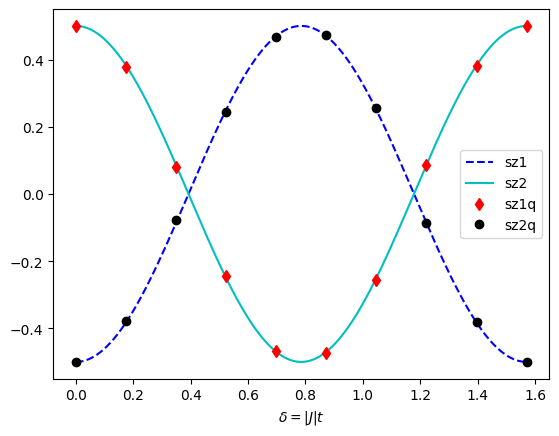

In [49]:
plt.plot(abs(J)*c_times,0.5*sz1_t,'b--')
plt.plot(abs(J)*c_times,0.5*sz2_t,'c')
plt.plot(abs(J)*q_times,0.5*sz1q_t,'rd')
plt.plot(abs(J)*q_times,0.5*sz2q_t,'ko')
plt.legend(['sz1','sz2','sz1q','sz2q'])
plt.xlabel(r'$\delta = |J|t$')
plt.show()

Some reference to move to more difficult scenario with Trotterization: https://qiskit.org/documentation/stubs/qiskit.opflow.evolutions.html
    

## Extra: what happens when $N>2$ 

Now we will study the more general case. 

Actually, we just need to add a spin to see the difference: the exponential $U_{\text{Heis3}}(t)$ cannot be split into a product of simpler exponentials. 
However, we can approximate $U_{\text{Heis3}}(t)$ as a product of simpler exponentials through Trotterization. 
Consider again the 2 spin case, within the larger 3 spin system. 
As we have seen the Hamiltonian on spins $i$ and $j$ ($i,j \in \{0,1,2\}$) is $H^{(i,j)}_{\text{Heis2}} = \sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}$. 
Rewritting $U_{\text{Heis3}}(t)$ in terms of the two possible subsystems within the total $N=3$ system you will simulate,

$$
U_{\text{Heis3}}(t) = \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right].
$$

$H^{(0,1)}_{\text{Heis2}}$ and $H^{(1,2)}_{\text{Heis2}}$ do not commute, so $U_{\text{Heis3}}(t) \neq \exp\left(-i t H^{(0,1)}_{\text{Heis2}}\right) \exp\left(-i t H^{(1,2)}_{\text{Heis2}} \right)$.
But, this product decomposition can be approximated with Trotterization which says $U_{\text{Heis3}}(t)$ is approximately a short evolution of $H^{(0,1)}_{\text{Heis2}}$ (time = $t/n$) and followed by a short evolution of $H^{(1,2)}_{\text{Heis2}}$ (time = $t/n$) repeated $n$ times

$$
\begin{align}
U_{\text{Heis3}}(t) &= \exp\left[-i t \left(H^{(0,1)}_{\text{Heis2}} + H^{(1,2)}_{\text{Heis2}} \right)\right] \\
U_{\text{Heis3}}(t) &\approx \left[\exp\left(\dfrac{-it}{n}H^{(0,1)}_{\text{Heis2}}\right) \exp\left(\dfrac{-it}{n}H^{(1,2)}_{\text{Heis2}} \right)\right]^n.
\end{align}
$$

$n$ is the number of Trotter steps, and as $n$ increases, the approximation becomes more accurate. (Note that how a untiary is split up into subsystems for Trotterization is not necessarily unique.) 

In [50]:
## Here we introduce a general function for Heisenberg chain Trotter evolution
## The circuit will not contain the initialisation

def Heisenberg_Trotter(num_spins,trotter_steps,t):
    
    '''
    Circuit implementing Trotterization of the time evolutiom operator for the XXX Heisenberg
    model on num_spins.
    
    Naively, every  Trotter step requires 6*(num_spins-1) CNOTs
    
    Args:
        - num_spins: int, number of qubits of the system
        - trotter_steps: the number of trotter steps n to implement
        - t: the simulation time we are targeting
        
    Returns:
        A QuantumCircuit implementing the Trotterization of the time evolutiom operator for the XXX Heisenberg
        model
    '''
    
    # Given a target time and a number of Trotter steps, every step will evolve the 
    # circuit for a time step dt = target_time/trotter_steps
    dt = t/trotter_steps

    # Initialize quantum circuit for n_spins
    qr = QuantumRegister(num_spins)
    # A QuantumCircuit can also be initialised without a classical register (in this case classical bits == qubits)
    qc = QuantumCircuit(qr) 
    
    for _ in range(trotter_steps):
        for i in range(0, num_spins - 1):
            qc.rxx(2*dt,i,i+1)
            qc.ryy(2*dt,i,i+1)
            qc.rzz(2*dt,i,i+1)
        
        # To separate the different Trotter steps
        qc.barrier()


    return qc

Now we will use the function created to compare the Trotterization with the exact evolution.

In [51]:
# Simulate the system with a different number of Trotter steps and compare with the matrix exponentiation
# In this case, we will consider 4, 8 and 12 Trotter steps
# Import Pauli operators (X, Y, Z) and the identity
from qiskit.opflow import I, X, Y, Z, One, Zero

probs_110_trott = {4:[],8:[],12:[]}

## Define where you want to run the circuit
backend     = Aer.get_backend("statevector_simulator")             # Exact
#backend     = QasmSimulator(shots=8000)                           # Shots
#backend     = QasmSimulator(noise_model=noise_model, shots= 8000) # Noisy

expectation = PauliExpectation() 
sampler     = CircuitSampler(backend)

## We want to measure |110><110|
prj = StateFn((1/8)*(I-Z)^(I-Z)^(I+Z),is_measurement=True)

# We loop over different number of Trotter steps
for n in probs_110_trott.keys():
    for sim_t in ts:
        # Initialize the circuit
        trott_qr = QuantumRegister(3)
        trott_qc = QuantumCircuit(trott_qr)
        trott_qc.x([1,2])
    
        # Append the Trotterization
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        #trott_qc   = trott_qc.compose(trott_steps)
        trott_qc.append(trott_steps, [trott_qr[0], trott_qr[1], trott_qr[2]])
        
        trott_expect  = expectation.convert(prj @ StateFn(trott_qc))
        trott_sample  = sampler.convert(trott_expect)
        probs_110_trott[n].append(trott_sample.eval().real)
        
    print(str(n)+" steps completed")

4 steps completed
8 steps completed
12 steps completed


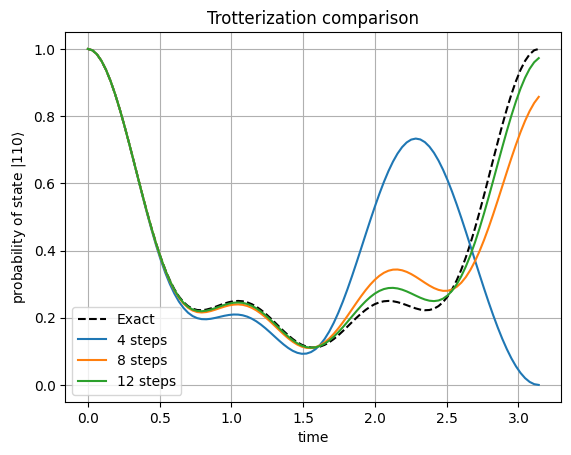

In [52]:
# Now plot the comparison
plt.plot(ts, probs_110_exact,linestyle="dashed",color="black",label="Exact")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('time')
plt.ylabel(r'probability of state $|110\rangle$')
plt.title(r'Trotterization comparison')
plt.legend()
plt.grid()
plt.show()

As we can see from the plot , the dynamics gets closer and closer to the exact state evolution as we increase the number of Trotter steps. 

This come at the cost of increasing the number of gates in our quantum circuit.